In [74]:
from torch.autograd import Variable
import torch
import torch.autograd
import torch.nn.functional as F
import random
import numpy as np
from params_poly import p
import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim
from tqdm import tqdm

  9%|▉         | 94/1000 [00:00<00:00, 937.77it/s]

loss: 2664300.750000 after 999 batches


  6%|▌         | 61/1000 [00:00<00:01, 601.90it/s]

loss: 0.000005 after 999 batches


  6%|▌         | 60/1000 [00:00<00:01, 594.33it/s]

loss: 7165.750488 after 999 batches


  4%|▍         | 40/1000 [00:00<00:02, 395.71it/s]

loss: 0.009569 after 999 batches


  3%|▎         | 30/1000 [00:00<00:03, 290.39it/s]

loss: 170036.031250 after 999 batches


100%|██████████| 1000/1000 [00:03<00:00, 292.95it/s]


loss: 1691845.750000 after 999 batches


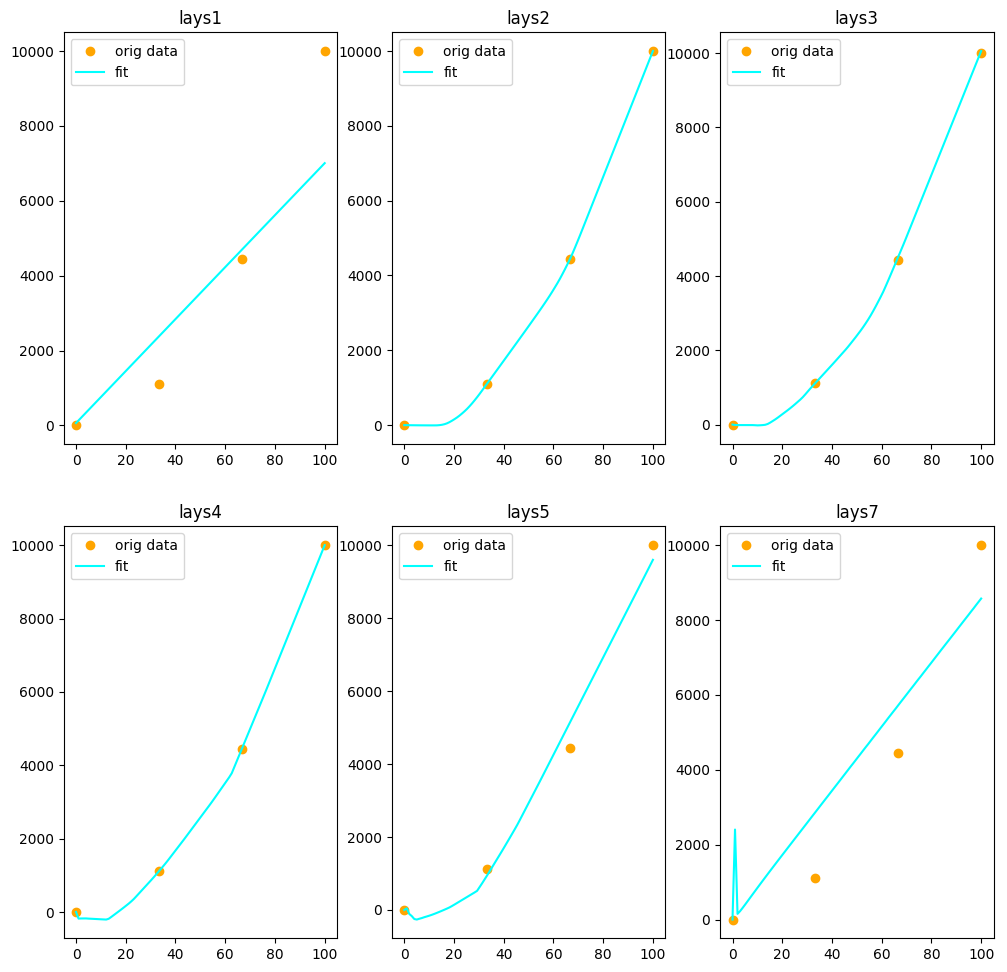

In [144]:
def poly(x):
    return x * x

def make_data():
    X = np.linspace(0, 100, 4)
    Y = np.apply_along_axis(poly, 0, X)
    return X, Y


def seed(p):
    # set random seed        
    np.random.seed(p.seed) 
    torch.manual_seed(p.seed)    
    random.seed(p.seed)
    
## network
class LinearNet(nn.Module):
    def __init__(self, num_layers, input_size, hidden_size, output_size):
        # num_layers is number of weight matrices
        super(LinearNet, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        # for one layer nets
        if num_layers == 1:
            self.fc = nn.ModuleList([nn.Linear(input_size, output_size)])
        else:
            self.fc = nn.ModuleList([nn.Linear(input_size, hidden_size)])
            self.fc.extend([nn.Linear(hidden_size, hidden_size) for i in range(num_layers - 2)])
            self.fc.append(nn.Linear(hidden_size, output_size))

    def forward(self, x):
        y = x.view(-1, self.input_size)
        for i in range(len(self.fc) - 1):
            y = F.relu(self.fc[i](y))
        return self.fc[-1](y)

freeze = False    
hidden_size = 1024
plt.figure(figsize=(12, 12), dpi=100, facecolor='white')
for i, nh in enumerate([1, 2, 3, 4, 5, 7]):

    seed(p)
    X, Y = make_data()
    X_t, Y_t = Variable(torch.Tensor(X)).cuda(), Variable(torch.Tensor(Y)).cuda()
    model = LinearNet(nh, input_size=1, hidden_size=hidden_size, output_size=1).cuda()

    
    if freeze:
        for name, param in model.named_parameters():
            if 'fc.0' in name:
                param.requires_grad = True 
            else:
                param.requires_grad = False
    
    # optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-6)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                          lr=1e-1) # wow Adam does way better
    criterion =  torch.nn.MSELoss()
    for batch_idx in tqdm(range(1000)):
        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        loss = criterion(model(X_t), Y_t)

        # Backward pass
        loss.backward()

        # Apply gradients
        optimizer.step()
    print('loss: {:.6f} after {} batches'.format(loss.data[0], batch_idx))


    def plot_model(X, Y, model):
        Xgrid = Variable(torch.Tensor(np.linspace(np.min(X), np.max(X), 100)))
        yhat = model(Xgrid.cuda()).data.cpu().numpy()
        plt.plot(X, Y, 'o', label='orig data', color='orange')
        plt.plot(Xgrid.data.numpy(), yhat, label='fit', color='cyan')
        plt.legend()

    R, C = 2, 3
    plt.subplot(R, C, i + 1)
    plt.title('lays' + str(nh))
    plot_model(X, Y, model)